Step 1: Import Libraries and Create Output Folder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import os

# Create an output folder if it doesn't exist
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Libraries imported and 'output' folder is ready.")

Libraries imported and 'output' folder is ready.


Step 2: Load and Merge Data


In [2]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
store_df = pd.read_csv('store.csv')

# Merge the data
train_df = pd.merge(train_df, store_df, on='Store')
test_df = pd.merge(test_df, store_df, on='Store')

print("Data loaded and merged successfully!")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26040\4275484191.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


Data loaded and merged successfully!


Step 3: Exploratory Data Analysis (EDA)


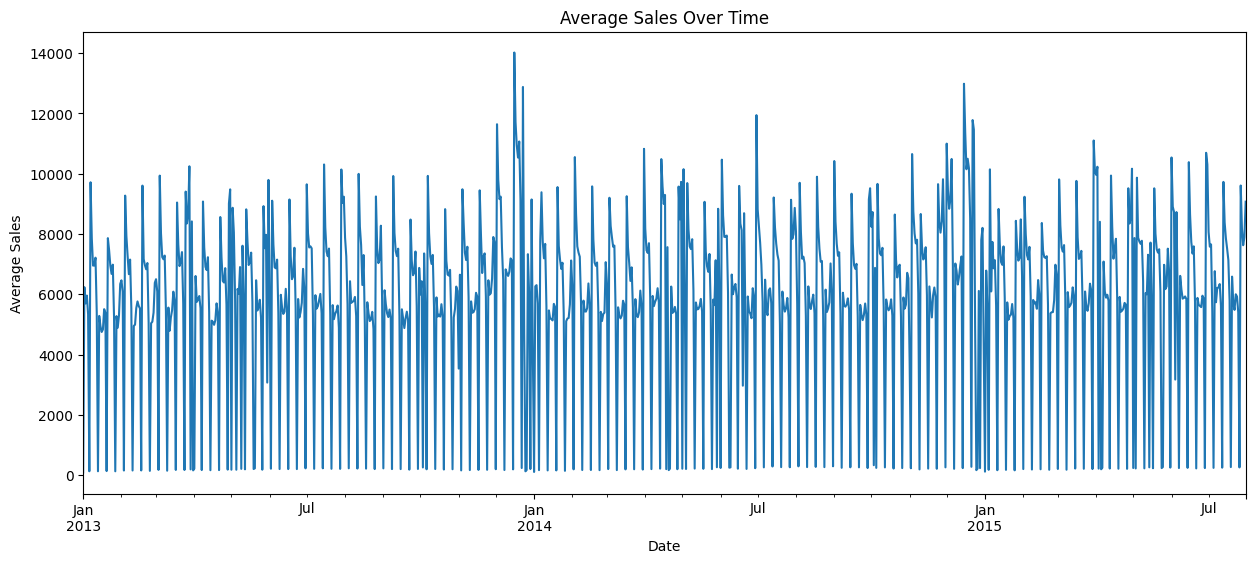

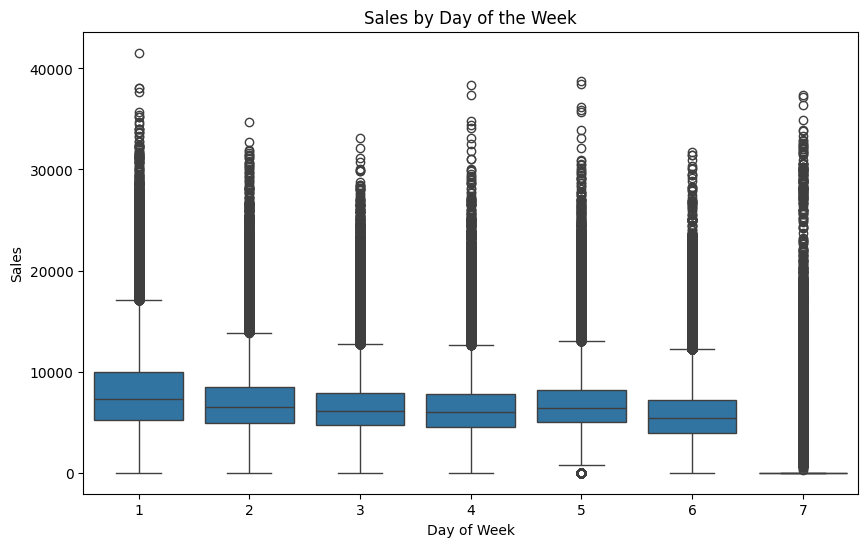

EDA plots have been saved to the 'output' folder.


In [3]:
# Convert 'Date' column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Sales over time
plt.figure(figsize=(15, 6))
train_df.groupby('Date')['Sales'].mean().plot(kind='line')
plt.title('Average Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.savefig(os.path.join(output_dir, 'average_sales_over_time.png'))
plt.show()

# Sales by Day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Sales', data=train_df)
plt.title('Sales by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.savefig(os.path.join(output_dir, 'sales_by_day_of_week.png'))
plt.show()

print("EDA plots have been saved to the 'output' folder.")

Step 4: Feature Engineering


In [4]:
def feature_engineering(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    
    # One-hot encode categorical features
    df = pd.get_dummies(df, columns=['StoreType', 'Assortment', 'StateHoliday'], drop_first=True)
    
    return df

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

print("Feature engineering complete!")

Feature engineering complete!


Step 5: Data Preprocessing


In [5]:
# Fill missing values
median_competition_distance = train_df['CompetitionDistance'].median()
train_df['CompetitionDistance'].fillna(median_competition_distance, inplace=True)
test_df['CompetitionDistance'].fillna(median_competition_distance, inplace=True)

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

print("Data preprocessing complete!")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26040\3418062282.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['CompetitionDistance'].fillna(median_competition_distance, inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26040\3418062282.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

Data preprocessing complete!


Step 6: Model Training


In [6]:
# Define features and target
features = [col for col in train_df.columns if col not in ['Date', 'Sales', 'Customers', 'PromoInterval']]
X = train_df[features]
y = train_df['Sales']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
          eval_metric='rmse', 
          callbacks=[lgb.early_stopping(100, verbose=False)])

print("Model training complete!")

Model training complete!


Step 7: Prediction and Submission


In [8]:
# The final list of features the model was trained on
train_cols = X_train.columns

# Prepare the test data for prediction by selecting and aligning columns
# 1. Select only the columns that are present in the training set
test_features_subset = test_df[test_df.columns.intersection(train_cols)]

# 2. IMPORTANT FIX: Reindex to align the test features with the training features.
#    Any columns missing in the test set (like 'StateHoliday_b') are added and filled with 0.
test_df_aligned = test_features_subset.reindex(columns=train_cols, fill_value=0)

# Make predictions
predictions = model.predict(test_df_aligned)

# Create submission file
submission = pd.DataFrame({
    "Id": test_df['Id'].astype(int), # Use original ID from test_df
    "Sales": predictions
})

submission_path = os.path.join(output_dir, 'submission.csv')
submission.to_csv(submission_path, index=False)

print(f"Predictions generated and saved to {submission_path}")
print("The KeyError is solved by re-indexing the test set columns.")

Predictions generated and saved to output\submission.csv
The KeyError is solved by re-indexing the test set columns.


In [11]:
# Assuming 'features' is a list of columns that were used to create X_train
# and should also be present in test_df *before* any alignment.

# 1. Ensure 'test_df' has the same features as 'X_train' by applying the feature extraction logic
#    (e.g., one-hot encoding) in the same way.

# 2. ALIGN COLUMNS (The corrected code for your problem):

train_cols = X_train.columns

# Check if a column from the training set is missing in the test set,
# and add it with a value of 0 (which is the result of missing a dummy variable).

missing_cols = set(train_cols) - set(test_df.columns)

# Loop through the columns missing in the test set and add them with a value of 0
for c in missing_cols:
    test_df[c] = 0

# Now, align the order and select only the columns that are in X_train
test_df = test_df[train_cols]

# Optional: Print to verify alignment
print(f"X_train columns: {len(X_train.columns)}")
print(f"test_df columns: {len(test_df.columns)}")
print(f"Are column names identical and in order? {all(X_train.columns == test_df.columns)}")

X_train columns: 24
test_df columns: 24
Are column names identical and in order? True


In [15]:
pip install pandas numpy matplotlib statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 1.4 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/9.6 MB 1.3 MB/s eta 0:00:07
   ---- ----------------------------------- 1.0/9.6 MB 1.4 MB/s eta 0:00:07
   ----- ---------------------------------- 1.3/9.6 MB 1.3 MB/s eta 0:00:07
   ----- ---------------------------------- 1.3/9.6 MB 1.3 MB/s eta 0:00:07
   ----- ---------------------------------- 1.3/9.6 MB 1.3 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.6 MB 932.8 kB/s eta 0:00:09
   ------ --------------------------------- 1.6/9.6 MB 932.8 kB/s eta 0:00:09
   ------- -------------------------------- 1.8/9.6 MB 852.5 kB/s eta 0:00:10
   ------- -------------------------------- 1.8/9.6 MB 852.5 kB/s eta 0:00:10
   -------- ----

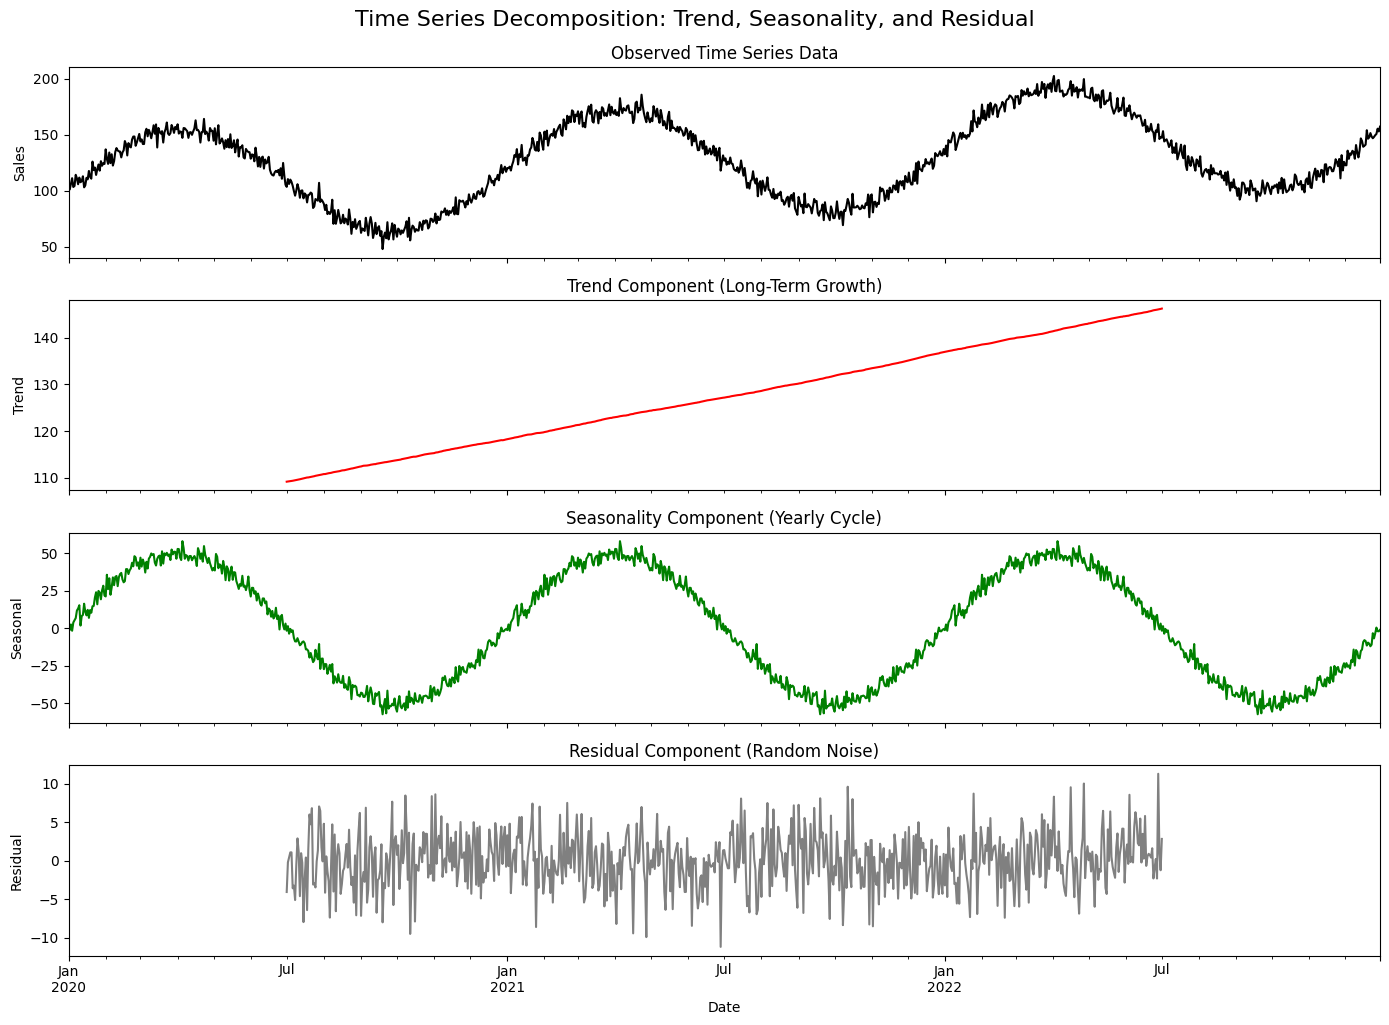

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Fitting SARIMA model...


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- 1. DATA GENERATION: Create Sample Data ---

# Set a random seed for reproducibility
np.random.seed(42)

# Create a time range of daily data for 3 years (1095 days)
date_rng = pd.date_range(start='2020-01-01', periods=1095, freq='D')
df = pd.DataFrame(date_rng, columns=['Date'])
df.set_index('Date', inplace=True)

# Generate a time series with a positive trend, yearly seasonality, and some noise
trend = np.arange(len(df)) * 0.05
seasonality_yearly = 50 * np.sin(2 * np.pi * df.index.dayofyear / 365.25)
noise = np.random.normal(0, 5, len(df))
df['Sales'] = 100 + trend + seasonality_yearly + noise

# Split data into training and validation (for forecasting)
train_size = int(len(df) * 0.9)
train_data = df['Sales'].iloc[:train_size]
full_data = df['Sales']

# --------------------------------------------------------------------------
# ## 2. Visualization 1: Decomposition (Trend and Seasonality)
# --------------------------------------------------------------------------
# The decomposition plot clearly separates the core components of the time series.

try:
    # Use additive model for decomposition (suitable when seasonal magnitude doesn't change with the trend)
    decomposition = seasonal_decompose(full_data, model='additive', period=365)

    # Create the plot
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

    # Observed
    decomposition.observed.plot(ax=axes[0], color='black', title='Observed Time Series Data')
    axes[0].set_ylabel('Sales')

    # Trend
    decomposition.trend.plot(ax=axes[1], color='red', title='Trend Component (Long-Term Growth)')
    axes[1].set_ylabel('Trend')

    # Seasonality
    decomposition.seasonal.plot(ax=axes[2], color='green', title='Seasonality Component (Yearly Cycle)')
    axes[2].set_ylabel('Seasonal')

    # Residual (Noise/Error)
    decomposition.resid.plot(ax=axes[3], color='gray', title='Residual Component (Random Noise)')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')

    plt.tight_layout()
    plt.suptitle('Time Series Decomposition: Trend, Seasonality, and Residual', fontsize=16, y=1.02)
    plt.show()
    

except Exception as e:
    print(f"\n--- DECOMPOSITION ERROR ---")
    print(f"An error occurred during decomposition: {e}")
    print("Ensure your time series index is a DatetimeIndex and the 'period' is correct.")

# --------------------------------------------------------------------------
# ## 3. Visualization 2: Forecast with Uncertainty
# --------------------------------------------------------------------------
# The forecast plot shows the predicted values and the 95% confidence interval.

try:
    # 3.1. Fit the SARIMA Model
    # A simple Seasonal ARIMA model is robust for data with trend and seasonality.
    # SARIMA(p, d, q)x(P, D, Q, s) - using a standard set of parameters for demonstration
    model = SARIMAX(train_data,
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 365), # 365 is the yearly seasonal period
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    print("\nFitting SARIMA model...")
    results = model.fit(disp=False) # disp=False suppresses convergence output
    print("Model fitting complete.")

    # 3.2. Generate Forecast
    forecast_steps = 180  # Predict 6 months into the future
    forecast = results.get_forecast(steps=forecast_steps)

    # Get prediction mean and confidence intervals (95% CI is default)
    pred_mean = forecast.predicted_mean
    pred_ci = forecast.conf_int()

    # 3.3. Create the Forecast Plot
    plt.figure(figsize=(16, 6))

    # Plot historical training data
    plt.plot(train_data.index, train_data.values, label='Historical Sales', color='blue')

    # Plot the predicted forecast
    plt.plot(pred_mean.index, pred_mean.values, label='Forecasted Sales (Trend & Seasonality)', color='red', linestyle='--')

    # Shade the uncertainty interval
    plt.fill_between(pred_ci.index,
                     pred_ci.iloc[:, 0],
                     pred_ci.iloc[:, 1],
                     color='pink', alpha=0.4, label='95% Confidence Interval')

    plt.title('Time Series Forecast (6 Months) with Uncertainty', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    


except Exception as e:
    print(f"\n--- FORECASTING ERROR ---")
    print(f"An error occurred during SARIMA forecasting: {e}")
    print("If the error persists, the model parameters (order/seasonal_order) may need adjustment for your specific data.")